# Magics

Magics are escape hatch syntax that allow you insert non-python syntax into a python cell withotu using string.

You can find two kinds of magics: 

- line magics (start with a single percent `%magic`)
- cell magics (start with a double percent `%%magic`)

Line magic will get the content of the **physical line** after the magic (up until the first following `\n`)
Cell magics will get the content of the line following them and the rest of the cell.

## A simple tic-toc magic

In this section we'll earn how to define our own IPython magic. Magics are usualy function (for stateless magics) or methods (usually for stateful magics or magics that needs

We'll want to time things later, so let's see if we can make a simple line magic that mesure the execution time of a function.

In [1]:
from IPython.core.magic import register_line_magic, register_line_cell_magic
import inspect

In [2]:
print(register_line_magic.__doc__)

Decorate the given function as line magic.

The decorator can be used with or without arguments, as follows.

i) without arguments: it will create a line magic named as the function being
decorated::

    @deco
    def foo(...)

will create a line magic named `foo`.

ii) with one string argument: which will be used as the actual name of the
resulting magic::

    @deco('bar')
    def foo(...)

will create a line magic named `bar`.

To register a class magic use ``Interactiveshell.register_magic(class or instance)``.

Note: this decorator can only be used in a context where IPython is already
active, so that the `get_ipython()` call succeeds.  You can therefore use
it in your startup files loaded after IPython initializes, but *not* in the
IPython configuration file itself, which is executed before IPython is
fully up and running.  Any file located in the `startup` subdirectory of
your configuration profile will be OK in this sense.



In [3]:
inspect.signature(compile)

<Signature (source, filename, mode, flags=0, dont_inherit=False, optimize=-1)>

In [4]:
# %load tictoc_solution.py
import datetime
import time

@register_line_magic
def tictoc(line):
    tic = datetime.datetime.now()
    exec(compile(line, '<dummy>', 'exec'), globals())
    toc = datetime.datetime.now()
    return (toc-tic).total_seconds()
    

In [5]:
def pyfib(n):
    if n < 2:
        return 1
    else:
        return pyfib(n-1) + pyfib(n-2)

In [6]:
dt = %tictoc pyfib(25)
dt

0.071353

Let's just graph the time it takes as a fucntion of of the input parameter:

In [7]:
pytimes = []
pyX = list(range(30))
for i in pyX:
    t = %tictoc pyfib(i)
    pytimes.append(t)
py = {"x":pyX, 'y':pytimes, 'label':'py'}

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
def compare(*args):
    fig, ax = plt.subplots()
    _min = min(args[0]['y'])
    for arg in args:
        _min = min(min(arg['y']), _min)
        ax.scatter(**arg)
    ax.set_yscale('log')
    ax.set_ylim(_min/10)
    ax.set_xlabel('n')
    ax.set_ylabel('time (s)')
    ax.legend()

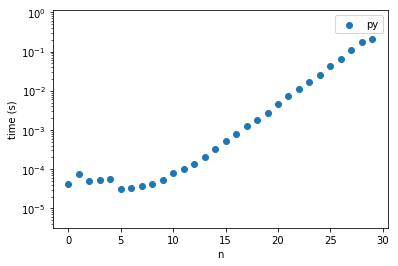

In [10]:
compare(py)

### Exercise:

 - Transform the above to a function
 - Observe that %tictoc does not have access to locals. 
 - You need to wrap it in `IPython.core.magics:@needs_local_scope` decorator, and make the funciton a class magic. 
 - Look at what `timeit` does, with the `-n` and `-r` and `-o` flags.

## Going faster 

As a case study for cross language integration we'll attempt to speed the above fibonacci function. 
From Physics we know that there is an absolute speed limit so let's use C. 

Here is the necessary header and source to get a working Fibonacci function in C. 

We'll fist do that manually, and then write a magic that automatically make this easier for us.

In [11]:
header = "int cfib(int);"
source = """
int cfib(int n){
    if (n < 4)
        return 1;
    else
        return cfib(n-1) + cfib(n-2);
}
"""

We don't want to work in vacuum, so let's use FFI, which allow us to easily compile C code on the fly. 

In [12]:
from cffi import FFI

An `FFI` object need to have at least `cdef()` and `set_source()` called with the right values.

In [17]:
filename = 'mycfibfile'
ffi = FFI()
ffi.cdef(header)
ffi.set_source(filename, source)

Let's compile the above into a shared object:

In [18]:
shared_object = ffi.compile()

let's import our newly created module, and look at what's inside

In [19]:
cfib_module = __import__(filename)
dir(cfib_module.lib)

['cfib']

And we finally get out c-based fibonacci function:

In [20]:
cfib = cfib_module.lib.cfib

In [21]:
print(cfib.__doc__)

int cfib(int);

CFFI C function from mycfibfile.lib


We can now compare its speed to the Python Fibbonacci we had before:

In [22]:
ctimes = []
cX = list(range(42))
for i in cX:
    t = %tictoc cfib(i)
    ctimes.append(t)
c = {"x":cX, 'y':ctimes, 'label':'C'}

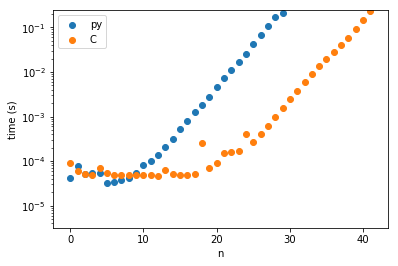

In [23]:
compare(py, c)

## Write a magic class. 

Staful Magics, or magics which needs to have access to IPython internals (like for example injecting variables in to namespaces) need to be full classes which methods will be called when the user invoke magics.

Your class needs to derive from `IPython.core.magic:Magics`, and should be decorated with `IPython.core.magic:@magics_class`. Each methods on this class will can be different magic when decorated with `@cell_magic` and similar. 

You will find below the skeletton of a magic to define inline C function. We've given you two useful pieces of code:

 - Generating a random filename (shared objects cannot be reloaded)
 - And how to inject a function with a given name in the user namespace. 
 
### Exercise:

Complete the code bellow using previsous section in order to compile a C function into a loadable Python module, and inject it into the user namespace.

In [24]:
from IPython.core.magic import magics_class, cell_magic, Magics
import string
from random import choice

@magics_class
class CFFI(Magics):
    
    @cell_magic
    def c(self, line, cell):
        rname = '_cffi_%s' % ''.join([choice(string.ascii_letters) for _ in range(10)])
        self.shell.user_ns['fib'] = lambda x:x
        

We need to manually register the class with IPython.

In [25]:
get_ipython().register_magics(CFFI)        

In [26]:
%%c int d(int); 
int d(int n){ return n*2;}

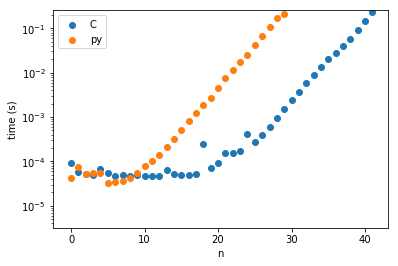

In [27]:
compare(c, py)

## About correctness 

Let's check that out implementation is correct, hopefully we should get the same values for both the Python and C based Fib functions. 

In [28]:
[(pyfib(i), cfib(i)) for i in range(10)]

[(1, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (5, 2),
 (8, 3),
 (13, 5),
 (21, 8),
 (34, 13),
 (55, 21)]

If the values differ, check that that changing the C source code and rerunning the function gives you the right value. 

## Implementation note:

We definitively did not choose the smartest algorithme for the fibonacci function. You can get much faster resuls

In [29]:
def ffib(n):
    if n < 2:
        return 1
    a,b = 1,1
    for i in range(n-2):
        a,b = b, a+b
    return b

In [30]:
t = %timeit -n1 -r1 -o ffib(23)


9.32 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [31]:

fftimes = []
ffX = list(range(100))
for i in ffX:
    t = %tictoc ffib(i)
    fftimes.append(t)
ff = {"x":ffX, 'y':fftimes, 'label':'C'}


In [32]:
x = %time 1+1 

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.5 µs


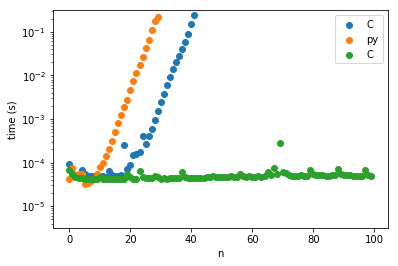

In [33]:
compare(c, py, ff)

## Cleanup

In [34]:
!rm -f mycfibfile.c
!rm -f mycfibfile.o